In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import defaultdict
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


Using TensorFlow backend.


# Load data 

First load all the CSV files we will need

In [2]:
data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We will check how balanced our training data is.

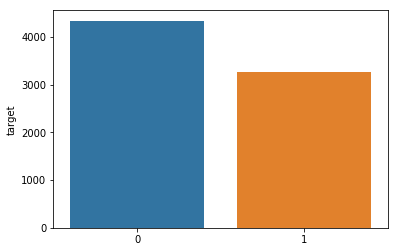

In [4]:
x=data.target.value_counts()
sns.barplot(x.index,x)

So there are more tweets with class 0(No disaster) as compared to class 1(Disaster tweets).

**Exploratory Data Analysis of tweets**

First,we will do very basic analysis,that is character level,word level and sentence level analysis.

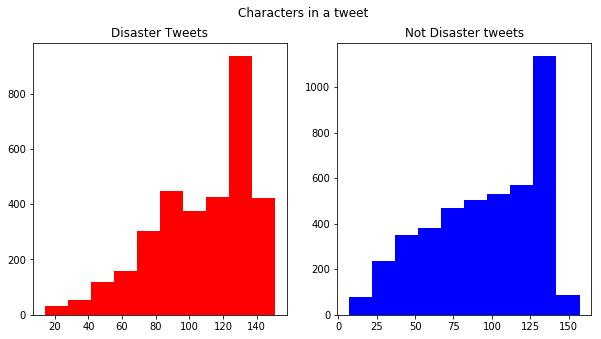

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data.target==1].text.str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster Tweets')
tweet_len=data[data.target==0].text.str.len()
ax2.hist(tweet_len,color='blue')
ax2.set_title('Not Disaster tweets')
fig.suptitle('Characters in a tweet')
plt.show()

so most of the tweets from both class of similar character range 120-140

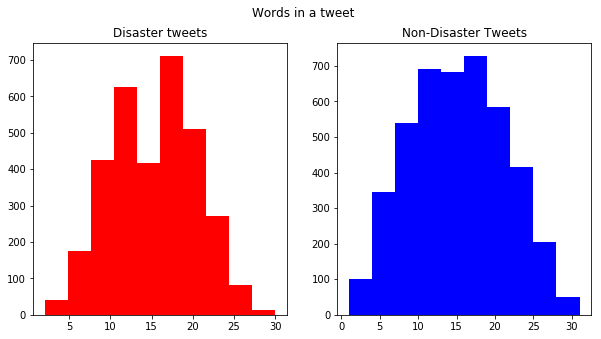

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data.target==1].text.str.split().map(lambda x:len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len=data[data.target==0].text.str.split().map(lambda x:len(x))
ax2.hist(tweet_len,color='blue')
ax2.set_title('Non-Disaster Tweets')
fig.suptitle('Words in a tweet')
plt.show()

Now finding average word length in a tweet

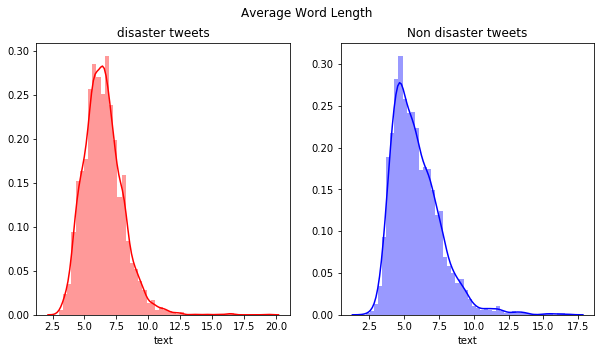

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=data[data.target==1].text.str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x:np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster tweets')
word=data[data.target==0].text.str.split().apply(lambda x:[len(i) for i in x])
sns.distplot(word.map(lambda x:np.mean(x)),ax=ax2,color='blue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Average Word Length')
plt.show()

In [12]:
def create_corpus(target):
    corpus=[]
    for x in data[data.target==target].text.str.split():
        for i in x:
            corpus.append(i)
    return corpus

first we will analyse the tweets with class 0

In [13]:
corpus=create_corpus(0)
dic=defaultdict(int)

for x in corpus:
    if x in stopwords.words('english'):
        dic[x]+=1
top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:10]    

In [14]:
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

<BarContainer object of 10 artists>

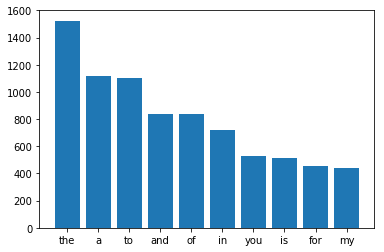

In [15]:

X,y=zip(*top)
plt.bar(X,y)

In [16]:
corpus=create_corpus(1)
dic=defaultdict(int)
for x in corpus:
    if x in stopwords.words('english'):
        dic[x]+=1
top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

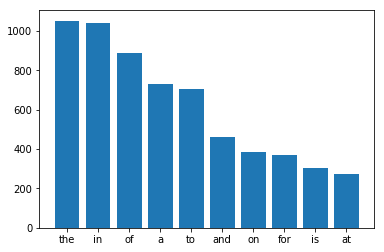

In [17]:
X,y=zip(*top)
plt.bar(X,y)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

**Analyzing Punctuations**

Analyzing punctuations in real disaster tweets

<BarContainer object of 18 artists>

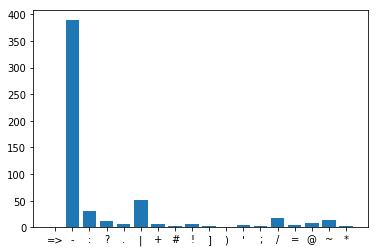

In [18]:
corpus=create_corpus(1)
dic=defaultdict(int)
import string
special=string.punctuation
for x in corpus:
    if x in special:
        dic[x]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Now analyzing non disaster tweets

<BarContainer object of 20 artists>

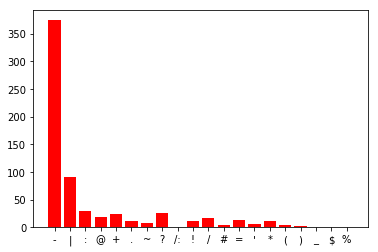

In [19]:
corpus=create_corpus(0)
dic=defaultdict(int)
for i in corpus:
    if i in special:
        dic[i]+=1
x,y=zip(*dic.items())
plt.bar(x,y,color='red')

Now we will find common words

In [20]:
from collections import Counter

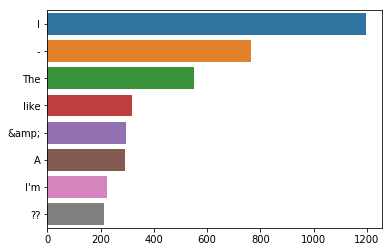

In [21]:
corpus1=create_corpus(0)
corpus2=create_corpus(1)
corpus=corpus1+corpus2
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stopwords.words('english')):
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

**Ngram analysis**

we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [23]:
def get_top_tweet_bigrams(corpus,n=None):
    vec=CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words=vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
    return words_freq[:n]

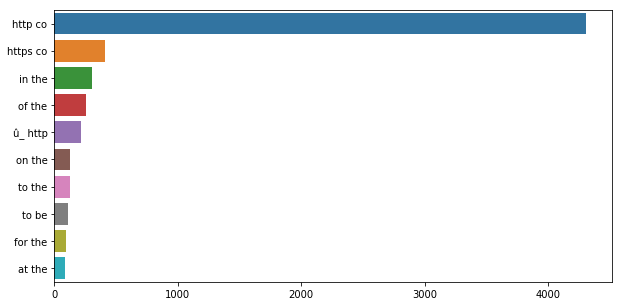

In [24]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(data['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

**Lot of cleaning is required**

**Data Cleaning**


As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [25]:
df=pd.concat([data,test])
df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

Removing URLs

In [26]:
def remove_urls(text):
     url = re.compile(r'https?://\S+|www\.\S+')
     return url.sub(r' ',text)


In [27]:
df['text']=df['text'].apply(lambda x:remove_urls(x))

**Removing HTML tags**

In [28]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r' ',text)

In [29]:
df['text']=df['text'].apply(lambda x:remove_html(x))

**Removing emoticons**

In [30]:
def remove_emoji(text):
    emoji_pattern=re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ',text)


In [31]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))


Removing punctuations

In [32]:
def remove_punctuations(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [33]:
df['text']=df['text'].apply(lambda x:remove_punctuations(x))


**Spelling Correction**

In [ ]:
!pip install pyspellchecker 

In [ ]:
from spellchecker import SpellChecker

In [ ]:
spell=SpellChecker()
def correct_spellings(text):
    corrected_text=[]
    mispelled_words=spell.unknown(text.split())
    for word in text.split():
        if word in mispelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return ' '.join(corrected_text)

In [ ]:
df['text']=df['text'].apply(lambda x: correct_spellings(x))


In [34]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stopwords.words('english')))]
        corpus.append(words)
    return corpus
        

In [35]:
from tqdm import tqdm

In [36]:
from nltk.tokenize import word_tokenize

In [37]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:32<00:00, 339.59it/s]


In [38]:
embedding_dict={}
with open('../input/glove-vectors/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [39]:
len(embedding_dict)

400000

In [40]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [41]:
sequences

[[622, 5467, 738, 175, 80, 1805, 3529, 16],
 [96, 7, 138, 739, 7970, 7971, 1308],
 [119, 1469, 1386, 2104, 645, 7972, 1667, 77, 204, 2104, 645, 1559, 1143],
 [12, 4239, 1185, 204, 1559, 40],
 [134, 26, 1387, 223, 5468, 2341, 211, 1185, 7973, 135],
 [2994, 357, 40, 1953, 787, 7974, 337, 1144, 328, 7, 5469, 1185],
 [136, 19, 817, 246, 999, 788, 224, 1668, 7975, 1045, 2616, 1669],
 [5, 151, 1954, 1, 43, 7, 4240],
 [270, 17, 204, 1145, 488, 789, 589],
 [5, 2105, 530, 176, 393],
 [439, 12, 440, 212, 358, 489],
 [818,
  554,
  2617,
  163,
  2618,
  4241,
  607,
  6,
  608,
  1,
  128,
  14,
  554,
  2617,
  99,
  683,
  1,
  177,
  87,
  279,
  99,
  683,
  1,
  177,
  87,
  279,
  7976,
  224],
 [3530, 224, 1955, 7977, 2617, 555, 238, 740, 3531],
 [136, 5470, 927, 74, 1560, 5470],
 [191, 135, 394, 4242, 64, 31, 291],
 [573, 46],
 [1, 48, 5471],
 [198, 1561],
 [28, 64, 768],
 [99, 7978],
 [3532],
 [1046, 556],
 [48, 7979],
 [99, 2342, 47],
 [7980],
 [77, 7981, 51, 1186, 152],
 [819, 1309, 6

In [42]:
tweet_pad.shape

(10876, 50)

In [43]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [57]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
print(embedding_matrix[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [58]:
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
print(embedding_matrix[100])

100%|██████████| 20342/20342 [00:00<00:00, 329131.89it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [51]:
num_words

20343

In [45]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [47]:
train=tweet_pad[:data.shape[0]]
test=tweet_pad[data.shape[0]:]

In [48]:
train

array([[ 622, 5467,  738, ...,    0,    0,    0],
       [  96,    7,  138, ...,    0,    0,    0],
       [ 119, 1469, 1386, ...,    0,    0,    0],
       ...,
       [ 396,  462, 1459, ...,    0,    0,    0],
       [  23, 1128, 3820, ...,    0,    0,    0],
       [   2,  147,   82, ...,    0,    0,    0]], dtype=int32)

In [49]:
X_train,X_test,y_train,y_test=train_test_split(train,data['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [50]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/10
 - 50s - loss: 0.6914 - accuracy: 0.5705 - val_loss: 0.6901 - val_accuracy: 0.5595
Epoch 2/10
 - 49s - loss: 0.6852 - accuracy: 0.5722 - val_loss: 0.6784 - val_accuracy: 0.5595
Epoch 3/10
 - 50s - loss: 0.6355 - accuracy: 0.6372 - val_loss: 0.5744 - val_accuracy: 0.7715
Epoch 4/10
 - 49s - loss: 0.5904 - accuracy: 0.7161 - val_loss: 0.5377 - val_accuracy: 0.7601
Epoch 5/10
 - 49s - loss: 0.5685 - accuracy: 0.7348 - val_loss: 0.5243 - val_accuracy: 0.7627
Epoch 6/10
 - 49s - loss: 0.5672 - accuracy: 0.7362 - val_loss: 0.5186 - val_accuracy: 0.7697
Epoch 7/10
 - 49s - loss: 0.5577 - accuracy: 0.7439 - val_loss: 0.5137 - val_accuracy: 0.7671
Epoch 8/10
 - 50s - loss: 0.5485 - accuracy: 0.7492 - val_loss: 0.5096 - val_accuracy: 0.7750
Epoch 9/10
 - 50s - loss: 0.5457 - accuracy: 0.7506 - val_loss: 0.5066 - val_accuracy: 0.7741
Epoch 10/10
 - 51s - loss: 0.5432 - accuracy: 0.7532 - val_loss: 0.5043 - val_accuracy: 0.7758


In [ ]:
data_corpus=create_corpus(data)

In [ ]:
for tweet in data_corpus:
    for word in tweet:
        print(word)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def clean_data (data):
    corpus = []
    pstem = PorterStemmer()

    for i in range(data.shape[0]):
        #Remove unwanted words
        tweet = re.sub("[^a-zA-Z]", ' ', data['text'][i])

        #Lower case
        tweet = tweet.lower()
        tweet = tweet.split()
    
        #Remove stop words and steeming words(take the roots)
        tweet = [pstem.stem(word) for word in tweet if not word in set (stopwords.words('english'))]
        tweet = ' '.join(tweet)
    
        #Append clean tweet to corpus
        corpus.append(tweet)
    return corpus

In [ ]:
def bag_of_words(data,data_corpus):
    uniqueWordFrequents={}
    for tweet in data_corpus:
        for word in tweet.split():
            if (word in uniqueWordFrequents.keys()):
                uniqueWordFrequents[word]+=1
            else:
                uniqueWordFrequents[word]=1
    uniqueWordFrequents=pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word_Frequency'])
    uniqueWordFrequents=uniqueWordFrequents[uniqueWordFrequents['Word_Frequency']>=20]
    from sklearn.feature_extraction.text import CountVectorizer
    countvec=CountVectorizer(max_features=uniqueWordFrequents.shape[0])
    bagwords=countvec.fit_transform(data_corpus).toarray()
    return bagwords

In [ ]:
data_corpus=clean_data(data)
data_bagwords=bag_of_words(data,data_corpus)

In [ ]:
X=data_bagwords
y=data['target']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
decisionTreeModel = DecisionTreeClassifier (criterion = 'entropy', max_depth=None, splitter ='best', random_state = 55)

In [ ]:
decisionTreeModel.fit(X_train,y_train)

In [ ]:
y_pred_train=decisionTreeModel.predict(X_train)
y_pred_test=decisionTreeModel.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_train,y_pred_train)*100


In [ ]:
accuracy_score(y_test,y_pred)*100

In [ ]:
from sklearn.linear_model import LogisticRegression

LogisticRegression = LogisticRegression(penalty='l2',solver='saga', random_state = 55)
LogisticRegression.fit(X_train, y_train)

In [ ]:
y_pred_train=LogisticRegression.predict(X_train)
y_pred_test=LogisticRegression.predict(X_test)

In [ ]:
accuracy_score(y_train,y_pred_train)*100

In [ ]:
accuracy_score(y_test,y_pred_test)*100

In [ ]:
from sklearn.linear_model import SGDClassifier


SGDClassifier = SGDClassifier(loss = 'hinge', 
                              penalty = 'l1',
                              learning_rate = 'optimal',
                              random_state = 55, 
                              max_iter=100)

SGDClassifier.fit(X_train,y_train)

In [ ]:
y_pred_train=SGDClassifier.predict(X_train)
y_pred_test=SGDClassifier.predict(X_test)

In [ ]:
accuracy_score(y_train,y_pred_train)*100


In [ ]:
accuracy_score(y_test,y_pred_test)*100